In [45]:
import json
import re
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt
import requests

os.chdir("..")
import utils

### Step 1: load cases

In [2]:
QUERY = "fence built on my property"

In [3]:
file_name = "data/output_{}.json".format(QUERY.replace(" ", "-"))

if os.path.exists(file_name):
    # load data
    with open(file_name, 'r') as f:
        cases = json.load(f)
else:
    # query data
    response = utils.get_request_caselaw("https://api.case.law/v1/cases/?search='{}'&full_case=TRUE".format(QUERY)).json()
    cases = response['results']
    
    i = 1 # limit to 5 requests (500 cases) because that should be more than enough
    while response['next'] and i < 5: 
        response = utils.get_request_caselaw(response['next']).json()
        cases.extend(response['results'])
        i += 1
    
    with open(file_name, 'w') as f:
        json.dump(cases, f)

Structure of `response` dict:
```
{  
    "count"    : total number of matching cases  
    "next"     : url to query for next 100 cases  
    "previous" : url to query for previous 100 cases  
    "results"  : [ (max length 100)
        {
            "name"          : **case name**
            "decision_date" : **case date**
            "citations"     : [
                {
                    "cite" : name of law
                    "type" : ??
                },
                ...
            ]
            "frontend_url"  : clean look at case
            "court"         : {
                "name" : level of court
            }
            "jurisdiction"  : {
                "name_long" : **name of US state (or if federal, 'United States')**
            }
            "casebody"      : { (if full_case=FALSE, this field is not present)
                "status" : should equal ok
                "data"   : {
                    "opinions"    : [ (for non-supreme court cases, just one opinion)
                        {
                            "author" : name of judge
                            "type"   : indicates type of opinion (majority/dissent/etc)
                            "text"   : **opinion text**
                        },
                        ...
                    ]
                    "head_matter" : **case description text**
            }
        },
        ...
    ]
}
```

### Step 2: pre-processing

In [4]:
for case in cases:
    # get rid of non-ok cases
    if case['casebody']['status'] != 'ok':
        cases.remove(case)
        continue

In [5]:
# enforce case ordering
case_names = [case['name'] for case in cases]

case_texts = [case['casebody']['data']['head_matter'].replace("\n", " ") for case in cases]
    
case_opinions = []
for opinions in [case['casebody']['data']['opinions'] for case in cases]:
    for opinion in opinions:
        if opinion['type'] == "majority":
            case_opinions.append(opinion['text'].replace("\n", " "))
            break

### Step 3: rank cases

In [6]:
# # define tokenizer that handles stemmings
# # sourced from https://gist.github.com/deargle/b57738c8ce2b4ed6ca90f86d5422431f
# trans_table = {ord(c): None for c in string.punctuation + string.digits}    
# stemmer = PorterStemmer()

# def tokenize(text):
#     return [stemmer.stem(word) for word in word_tokenize(text.translate(trans_table)) if len(word) > 1]
    
# # compute tf-idf scores
# vec = TfidfVectorizer(tokenizer=tokenize, 
#                       min_df=.05, 
#                       max_df=0.8, 
#                       max_features=5000, 
#                       stop_words=[stemmer.stem(item) for item in ENGLISH_STOP_WORDS], 
#                       norm='l2')

# compute tf-idf scores
vec = TfidfVectorizer(min_df=.05, 
                      max_df=0.8, 
                      max_features=5000, 
                      stop_words='english', 
                      norm='l2')

tfidf_matrix = vec.fit_transform(case_texts + [QUERY]).toarray()
tokens = vec.get_feature_names()

print("(stemmed) tokens considered by vectorizer:")
print(tokens)

(stemmed) tokens considered by vectorizer:
['000', '10', '100', '11', '12', '13', '14', '15', '150', '16', '17', '18', '1889', '19', '1907', '1st', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2d', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3d', '40', '41', '42', '43', '44', '45', '46', '50', '52', '54', '55', '57', '59', '60', '61', '63', '64', '66', '70', '78', '80', '81', '88', '91', '99', 'absence', 'accepted', 'accordance', 'according', 'account', 'acquiescence', 'acquired', 'acre', 'acres', 'act', 'acting', 'action', 'acts', 'actual', 'actually', 'addition', 'adjacent', 'adjoining', 'admissible', 'admission', 'admitted', 'adverse', 'affect', 'affirmed', 'aforesaid', 'agent', 'agree', 'agreed', 'agreement', 'al', 'alleged', 'alleges', 'allen', 'allow', 'allowed', 'animals', 'answer', 'app', 'appeal', 'appealed', 'appeals', 'appear', 'appeared', 'appears', 'appellant', 'appellants', 'appellate', 'appellee', 'appellees', 'application', 'applied', 'a

In [7]:
# compute cosine similarity of cases to search query
query_vec = tfidf_matrix[-1]
scores = [cosine_similarity(query_vec.reshape(1,-1), doc_vec.reshape(1,-1))[0][0] for doc_vec in tfidf_matrix[:-1]]

In [8]:
# display results
cosine_similarities = [(k,v, case_names.index(k)) for k,v in zip(case_names, scores)]
results = pd.DataFrame(cosine_similarities, columns=['case_name', 'score', 'original_rank']).sort_values('score', ascending=False).reset_index(drop=True)
results.head(20)

,case_name,score,original_rank
0,Thayer vs. Wright,0.306225,5
1,ROWLAND v. BAIRD,0.305989,0
2,Smith versus Johnson,0.295209,6
3,"Philip Saperstein, Plaintiff, v. Daniel Berman...",0.282951,2
4,GOODALE v. SOWELL,0.257046,14
5,Jim Langston et al. v. G. H. Maxey,0.248051,3
6,"Gulf, Colorado & Santa Fe Railway Co. v. E. B....",0.247283,21
7,Benjamin Wright against Martin Wright,0.247059,34
8,Krum & Peters versus Anthony,0.235049,211
9,Davis vs. Townsend,0.233323,110


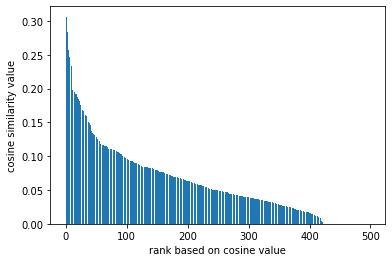

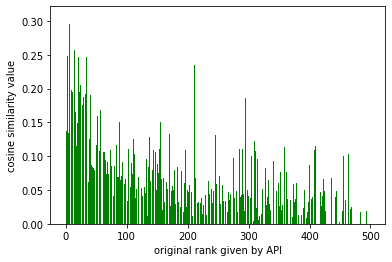

In [9]:
plt.bar(results.index, results.score)
plt.xlabel('rank based on cosine value')
plt.ylabel('cosine similarity value')
plt.show()
plt.bar(results.original_rank, results.score, color='green')
plt.xlabel('original rank given by API')
plt.ylabel('cosine similarity value')
plt.show()

### Step 4: determine outcome of case

In [10]:
opinion_counts = {}
for idx, case in enumerate(cases):
    try:
        opinion_counts[len(case['casebody']['data']['opinions'])] += 1
    except KeyError:
        opinion_counts[len(case['casebody']['data']['opinions'])] = 1

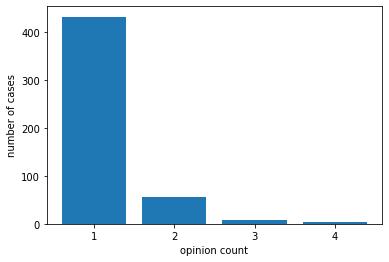

In [11]:
plt.bar(opinion_counts.keys(), opinion_counts.values())
plt.xticks(range(1,len(opinion_counts)+1))
plt.xlabel('opinion count')
plt.ylabel('number of cases')
plt.show()

In [12]:
[idx for idx in range(len(cases)) if cases[idx]['decision_date'][:4] > '2000']

[50, 120, 121, 136, 296, 325, 338, 349, 385, 404, 406, 432, 448, 450, 463, 493]

In [13]:
for case_index in range(len(cases)):
    print("CASE {}:".format(case_index))
    occurrences = [loc.start() for loc in re.finditer("(verdict|judgment)[ \w]* for the (plaintiff|defendant)", case_opinions[case_index], re.IGNORECASE)]
    if occurrences:
        for occ in occurrences:
            print(case_opinions[case_index][occ-50:occ+50])
    else:
        print("not found")

CASE 0:
not found
CASE 1:
not found
CASE 2:
not found
CASE 3:
ject to sale under execution. There was a general verdict for the plaintiff and a judgment perpetuat
CASE 4:
not found
CASE 5:
not found
CASE 6:
not found
CASE 7:
not found
CASE 8:
not found
CASE 9:
not found
CASE 10:
not found
CASE 11:
not found
CASE 12:
not found
CASE 13:
not found
CASE 14:
not found
CASE 15:
pon or over the line as so established, then your verdict must be for the defendant.” To have affirm
CASE 16:
not found
CASE 17:
not found
CASE 18:
not found
CASE 19:
not found
CASE 20:
not found
CASE 21:
not found
CASE 22:
not found
CASE 23:
not found
CASE 24:
not found
CASE 25:
not found
CASE 26:
not found
CASE 27:
truction than a direction to the jury to return‘a verdict for the defendant. The evidence of the pla
CASE 28:
not found
CASE 29:
not found
CASE 30:
not found
CASE 31:
nce and voluntarily left the same open, then your verdict must be for the plaintiff.” We find no err
CASE 32:
not found
CASE 33:
metes and 

not found
CASE 308:
not found
CASE 309:
not found
CASE 310:
 another. The Superior Court is advised to render judgment for the plaintiffs, and to pass a decree 
CASE 311:
not found
CASE 312:
not found
CASE 313:
te county. In that court a verdict was found, and judgment given for the defendant, and to reverse t
CASE 314:
not found
CASE 315:
not found
CASE 316:
not found
CASE 317:
not found
CASE 318:
not found
CASE 319:
not found
CASE 320:
not found
CASE 321:
not found
CASE 322:
not found
CASE 323:
not found
CASE 324:
not found
CASE 325:
not found
CASE 326:
not found
CASE 327:
 sufficient to sustain the action, and directed a verdict for the defendant. In this, notwithstandin
CASE 328:
not found
CASE 329:
not found
CASE 330:
not found
CASE 331:
d the cause will be remanded, with direction that judgment be entered for the plaintiff. Valentine, 
CASE 332:
not found
CASE 333:
not found
CASE 334:
r possession by sale or transfer in any way, your verdict should be for the plaintiff for the po

In [32]:
response = requests.get("https://www.courtlistener.com/api/rest/v3/courts/?format=json").json()
courts = response['results']

while response['next']: 
    response = requests.get(response['next']).json()
    courts.extend(response['results'])

In [36]:
court_types = {court['full_name']: court['jurisdiction'] for court in courts}

In [58]:
courts_included = set(court_types.keys())

for case in cases:
    court_name = case['court']['name']
    print(court_name)
    closest_court = ""
    
    # look for pure match first   
    if court_name in courts_included:
        closest_court = court_name
    else:
        # try jaccard
        max_score = 0
        closest_court = ""
        court1_tokens = set(court_name.split())
        for court2 in courts_included:
            court2_tokens = set(court2.split())
            score = float(len(court1_tokens & court2_tokens)) / len(court1_tokens | court2_tokens)
            if score > max_score:
                max_score = score
                closest_court = court2
        
    print(court_types[closest_court])

Montgomery County Court
FS
Idaho Supreme Court
S
New York Supreme Court
ST
Supreme Court of Texas
S
New York Supreme Court, General Term
ST
New York Supreme Court
ST
Supreme Court of Pennsylvania
S
Wisconsin Supreme Court
S
Superior Court of Pennsylvania
SA
Brooklyn City Court
SS
Massachusetts Supreme Judicial Court
S
Supreme Court of South Carolina
S
Kentucky Court of Appeals
SA
Supreme Court of Pennsylvania
S
Supreme Court of South Carolina
S
Superior Court of Pennsylvania
SA
Texas Courts of Civil Appeals
SA
Illinois Supreme Court
S
United States Court of Appeals for the Ninth Circuit
F
County Court of New York, Niagara County
SA
Nebraska Supreme Court
S
Texas Courts of Civil Appeals
SA
Illinois Appellate Court
SA
Cambria County Court of Quarter Sessions
S
Supreme Court of Pennsylvania
S
Cuyahoga Circuit Court
FD
Cuyahoga County Circuit Court
FD
Supreme Court of California
S
Brooklyn City Court
SS
Wisconsin Supreme Court
S
Superior Court of Pennsylvania
SA
Kansas City Court of Appeal

Supreme Court of Georgia
S
Supreme Court of California
S
Iowa Supreme Court
S
New York Court of Appeals
S
Nebraska Supreme Court
S
Texas Courts of Civil Appeals
SA
Arkansas Supreme Court
S
Supreme Court of Texas
S
Texas Courts of Civil Appeals
SA
District Court of Appeal of the State of California
SA
Colorado Supreme Court
S
Mississippi Court of Appeals
SA
Supreme Court of California
S
Oregon Court of Appeals
SA
Michigan Supreme Court
S
Alabama Supreme Court
S
Minnesota Supreme Court
S
Louisiana Supreme Court
S
New York Court of Appeals
S
Kentucky Court of Appeals
SA
Oregon Supreme Court
S
Montana Supreme Court
S
District Court of Appeal of the State of California
SA
United States District Court for the Eastern District of Pennsylvania
F
United States District Court for the District of Alaska
F
New York Supreme Court
ST
Montana Supreme Court
S
Supreme Court of Appeals of West Virginia
S
Iowa Supreme Court
S
Texas Courts of Civil Appeals
SA
Supreme Court of Missouri
S
Supreme Court of T